In [2]:
from typing import Tuple
import itertools
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from monai.networks import nets, one_hot
from monai.metrics import compute_hausdorff_distance

import plotly.express as px
from plotly.colors import n_colors
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = "simple_white"

import skimage as skm
from scipy import interpolate

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms

import torchio as tio

from kedro.extras.datasets.pandas import CSVDataSet
from kedro.extras.datasets.pickle import PickleDataSet

In [3]:
import os, sys
sys.path.append(os.path.abspath('../src'))

from tagseg.data import ScdEvaluator, MnmEvaluator
from tagseg.data.dmd_dataset import DmdH5DataSet, DmdH5Evaluator
from tagseg.models.trainer import Trainer
from tagseg.models.segmenter import Net
from tagseg.metrics.dice import DiceMetric
from tagseg.pipelines.model_evaluation.nodes import tag_subjects
from tagseg.data.dmd_dataset import DmdDataSet

In [4]:
top_h_legend = dict(orientation='h', yanchor="bottom", y=1.1)

In [5]:
index = pd.read_csv('../data/07_model_output/index.csv')
index

architecture                                     strategy  \
0       nnUnet                                 From scratch   
1       nnUnet  Pretrain with physics-driven transformation   
2       nnUnet                       Pretrain with CycleGAN   
3    ResNetVAE                                 From scratch   
4    ResNetVAE  Pretrain with physics-driven transformation   
5    ResNetVAE                       Pretrain with CycleGAN   

                            model  
0                    model_dmd_v2  
1  model_cine_v8_simtag_v1_dmd_v1  
2     model_cine_v8_tag_v1_dmd_v2  
3                    model_dmd_v1  
4  model_cine_v6_simtag_v1_dmd_v1  
5     model_cine_v6_tag_v1_dmd_v2

In [6]:
dfs = [] 

for _, row in index.iterrows():

    for split in ['train', 'test']:

        ext = '_train' if split == 'train' else ''

        df = PickleDataSet(filepath=f'../data/07_model_output/{row.model}/dmd_results{ext}.pt').load()
        df = pd.DataFrame(list(df))

        df['architecture'] = row.architecture
        df['strategy'] = row.strategy
        df['split'] = split

        dfs.append(df)

In [7]:
df = pd.concat(dfs)
len(df)

7500

In [6]:
results = df.pivot_table(index=['architecture', 'strategy'], values=['dice', 'hd95'], columns=['split'], aggfunc=['mean', 'std']) \
    .sort_index(level=[1, 2, 0], ascending=[True, False, True], axis=1).reorder_levels([1, 2, 0], axis=1) \
    .sort_index(level=[0, 1], ascending=[False, False]) \

results

dice            \
split                                                         train             
                                                               mean       std   
architecture strategy                                                           
SegResNetVAE From scratch                                  0.919866  0.020299   
             Fine-tune with physics-driven transformation  0.944873  0.016117   
             Fine-tune with CycleGAN                       0.944103  0.016005   
DynUNet      From scratch                                  0.951225  0.015178   
             Fine-tune with physics-driven transformation  0.958844  0.015228   
             Fine-tune with CycleGAN                       0.959414  0.015398   

                                                                               \
split                                                          test             
                                                               mean       std   
architecture strategy                                                           
SegResNetVAE From scratch                                  0.776869  0.097761   
             Fine-tune with physics-driven transformation  0.830135  0.068729   
             Fine-tune with CycleGAN                       0.836217  0.047164   
DynUNet      From scratch                                  0.785333  0.094445   
             Fine-tune with physics-driven transformation  0.801129  0.042255   
             Fine-tune with CycleGAN                       0.805395  0.059789   

                                                               hd95            \
split                                                         train             
                                                               mean       std   
architecture strategy                                                           
SegResNetVAE From scratch                                  1.901702  0.563619   
             Fine-tune with physics-driven transformation  1.410673  0.450826   
             Fine-tune with CycleGAN                       1.407372  0.446809   
DynUNet      From scratch                                  1.224053  0.387454   
             Fine-tune with physics-driven transformation  2.301424  1.058428   
             Fine-tune with CycleGAN                       1.154627  0.356447   

                                                                               
split                                                          test            
                                                               mean       std  
architecture strategy                                                          
SegResNetVAE From scratch                                  6.760752  8.413045  
             Fine-tune with physics-driven transformation  4.498713  2.992218  
             Fine-tune with CycleGAN                       3.984456  1.257573  
DynUNet      From scratch                                  6.255192  4.804180  
             Fine-tune with physics-driven transformation  5.063557  1.148645  
             Fine-tune with CycleGAN                       4.846081  1.458943

In [7]:
print(results.to_latex(
    float_format="%.3f", bold_rows=True, column_format='llrrrrrrrr', multicolumn_format='c', multirow=True,
    caption='Something retarded'
))

\begin{table}
\centering
\caption{Something retarded}
\begin{tabular}{llrrrrrrrr}
\toprule
        & {} & \multicolumn{4}{c}{dice} & \multicolumn{4}{c}{hd95} \\
        & \textbf{split} & \multicolumn{2}{c}{train} & \multicolumn{2}{c}{test} & \multicolumn{2}{c}{train} & \multicolumn{2}{c}{test} \\
        & {} &  mean &   std &  mean &   std &  mean &   std &  mean &   std \\
\textbf{architecture} & \textbf{strategy} &       &       &       &       &       &       &       &       \\
\midrule
\multirow{3}{*}{\textbf{SegResNetVAE}} & \textbf{From scratch} & 0.920 & 0.020 & 0.777 & 0.098 & 1.902 & 0.564 & 6.761 & 8.413 \\
        & \textbf{Fine-tune with physics-driven transformation} & 0.945 & 0.016 & 0.830 & 0.069 & 1.411 & 0.451 & 4.499 & 2.992 \\
        & \textbf{Fine-tune with CycleGAN} & 0.944 & 0.016 & 0.836 & 0.047 & 1.407 & 0.447 & 3.984 & 1.258 \\
\cline{1-10}
\multirow{3}{*}{\textbf{DynUNet}} & \textbf{From scratch} & 0.951 & 0.015 & 0.785 & 0.094 & 1.224 & 0.387 & 6.255 & 4.8

/tmp/ipykernel_62182/318273618.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(


In [8]:
df = df[df.split == 'test']

In [155]:
df.patient_id = df.patient_id.astype(str)
df.head()

image  \
0  {'data': [[tensor([[-2.0357, -2.0357, -2.0357,...   
1  {'data': [[tensor([[-2.0357, -2.0357, -2.0357,...   
2  {'data': [[tensor([[-2.0357, -2.0357, -2.0357,...   
3  {'data': [[tensor([[-2.0357, -2.0357, -2.0357,...   
4  {'data': [[tensor([[-2.0357, -2.0357, -2.0357,...   

                                                mask  \
0  {'data': [[tensor([[0., 0., 0.,  ..., 0., 0., ...   
1  {'data': [[tensor([[0., 0., 0.,  ..., 0., 0., ...   
2  {'data': [[tensor([[0., 0., 0.,  ..., 0., 0., ...   
3  {'data': [[tensor([[0., 0., 0.,  ..., 0., 0., ...   
4  {'data': [[tensor([[0., 0., 0.,  ..., 0., 0., ...   

                                                pred      dice      hd95  \
0  {'data': [[tensor([[0, 0, 0,  ..., 0, 0, 0],
 ...  0.655353  8.062258   
1  {'data': [[tensor([[0, 0, 0,  ..., 0, 0, 0],
 ...  0.716862  6.555664   
2  {'data': [[tensor([[0, 0, 0,  ..., 0, 0, 0],
 ...  0.719774  7.364026   
3  {'data': [[tensor([[0, 0, 0,  ..., 0, 0, 0],
 ...  0.713598  9.170297   
4  {'data': [[tensor([[0, 0, 0,  ..., 0, 0, 0],
 ...  0.742429  6.708204   

   timeframe group subgroup  disease location patient_id slice architecture  \
0          0     1        0  control     UCLA        008  base      DynUNet   
1          1     1        0  control     UCLA        008  base      DynUNet   
2          2     1        0  control     UCLA        008  base      DynUNet   
3          3     1        0  control     UCLA        008  base      DynUNet   
4          4     1        0  control     UCLA        008  base      DynUNet   

  strategy  
0  scratch  
1  scratch  
2  scratch  
3  scratch  
4  scratch

In [94]:
fig = make_subplots(rows=2, cols=2, shared_yaxes=True, shared_xaxes=True, horizontal_spacing=0.02, vertical_spacing=0.10)

df['strategy'].replace('Pretrain with physics-driven transformation', 'Physics-driven', inplace=True)
df['strategy'].replace('Pretrain with CycleGAN', 'CycleGAN', inplace=True)

for m, metric in enumerate(['dice', 'hd95']):
    for i, (a, s, d) in enumerate(itertools.product(df.architecture.unique(), df.strategy.unique(), df.disease.unique())):

        fdf = df[(df.architecture == a) & (df.strategy == s) & (df.disease == d)]
        
        fig.add_trace(
            go.Violin(
                x=fdf.strategy, y=fdf[metric],
                legendgroup=d, scalegroup=d, name=d.upper(), side='negative' if d == 'control' else 'positive',
                line_color='#197278' if d == 'control' else '#C44536', showlegend=True if i in [0, 1] and m == 1 else False,
            ), row=m + 1, col=1 if a == 'nnUnet' else 2
        )
        
        if m == 1:
            fig.update_xaxes(title_text=a, row=2, col=1 if a == 'nnUnet' else 2)

fig.update_yaxes(title_text='Dice coefficient (DSC)', range=[0, 1], row=1, col=1)
fig.update_yaxes(title_text='Hausdorff distance (95%)', range=[0, 25], row=2, col=1)
fig.update_traces(meanline_visible=True, width=.9, points=False)
fig.update_layout(violingap=0, violinmode='overlay', height=600, width=700, legend=top_h_legend)
fig.show()

In [95]:
fig.write_image("../../figures/disease-perf-violin.pdf")

In [19]:
df.melt(id_vars=['patient_id', 'architecture', 'strategy'], value_vars=['dice', 'hd95']).head()

patient_id architecture      strategy variable     value
0        008       nnUnet  From scratch     dice  0.655353
1        008       nnUnet  From scratch     dice  0.716862
2        008       nnUnet  From scratch     dice  0.719774
3        008       nnUnet  From scratch     dice  0.713598
4        008       nnUnet  From scratch     dice  0.742429

In [9]:
colors = ['#219EBC', '#FB8500', '#023047']

fig = px.strip(
    df.melt(id_vars=['patient_id', 'architecture', 'strategy'], value_vars=['dice', 'hd95']), 
    x='patient_id', y='value', color='strategy', facet_col='architecture', facet_row='variable',
    labels=dict(patient_id='Patient ID', variable='Performance metric', strategy='Training strategy', architecture='Model architecture'),
    color_discrete_sequence=colors
)
fig.update_yaxes(matches=None)
fig.update_layout(legend=top_h_legend)

fig.update_yaxes(title_text='Hausdorff distance (95%)', range=[0, 25], row=1, col=1)
for a, s in itertools.product(df.architecture.unique(), df.strategy.unique()):
    avg = df[(df.architecture == a) & (df.strategy == s)].hd95.mean()
    fig.add_hline(
        y=avg, line_width=3, line_dash="dot", line_color=colors[list(df.strategy.unique()).index(s)], row=1, col=int(a == 'nnUnet')
    )

fig.update_yaxes(title_text='Dice coefficient (DSC)', range=[0, 1], row=2, col=1)
for a, s in itertools.product(df.architecture.unique(), df.strategy.unique()):
    avg = df[(df.architecture == a) & (df.strategy == s)].dice.mean()
    fig.add_hline(
        y=avg, line_width=3, line_dash="dot", line_color=colors[list(df.strategy.unique()).index(s)], row=2, col=int(a == 'nnUnet')
    )

fig.update_layout(height=800, width=800)
fig.show()

/opt/conda/envs/tagseg/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [10]:
fig.write_image("../../figures/patient-performance-strip.pdf")

In [118]:
colors = n_colors('rgb(25, 114, 120)', 'rgb(196, 69, 54)', 25, colortype='rgb')

fig = make_subplots(rows=2, cols=3, shared_yaxes=True, shared_xaxes=True, horizontal_spacing=0.02, vertical_spacing=0.02)
strategies = ["From scratch", "Physics-driven", "CycleGAN"]

for i, architecture in enumerate(df.architecture.unique()):

    fig.update_yaxes(title_text=f'{architecture}<br>Timeframe', row=i + 1, col=1)

    for j, strategy in enumerate(df.strategy.unique()):

        fig.update_xaxes(title_text=f'Dice coefficient (DSC)<br>{strategies[j]}', row=2, col=j + 1)

        data = np.array(list(map(lambda t: np.array(df[(df.timeframe == t) & (df.architecture == architecture) & (df.strategy == strategy)].dice), range(25))))

        for t, (data_line, color) in enumerate(zip(data, colors)):
            fig.add_trace(go.Violin(name=t + 1, x=data_line, line_color=color), row=i + 1, col=j + 1)
            fig.update_xaxes(range=[0.1, 1.2], tickvals=np.arange(0.2, 1.1, 0.1,), row=i + 1, col=j + 1)
            fig.update_yaxes(range=[-1, 28], tickvals=np.arange(0, 30, 5), ticktext=np.arange(0, 30, 5), row=i + 1, col=j + 1)
        
        fig.add_vline(
            x=data.mean(),
            annotation_text=f"     {data.mean():.3f}", annotation_position="top right", 
            annotation_font_color='rgb(40, 61, 59)',
            line_width=3, line_dash="dot", line_color='rgb(40, 61, 59)', row=i + 1, col=j + 1)

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(height=700, width=800, showlegend=False)
fig.show()

/opt/conda/envs/tagseg/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [119]:
fig.write_image("../../figures/model-performance-violin.pdf")

In [62]:
points = contour[::5, ::-1]

/opt/conda/envs/tagseg/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1721: DeprecationWarning: NONE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.convert(mode='P', dither=Image.NONE,
/opt/conda/envs/tagseg/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1722: DeprecationWarning: ADAPTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Palette.ADAPTIVE instead.
  palette=Image.ADAPTIVE, colors=num_colors)


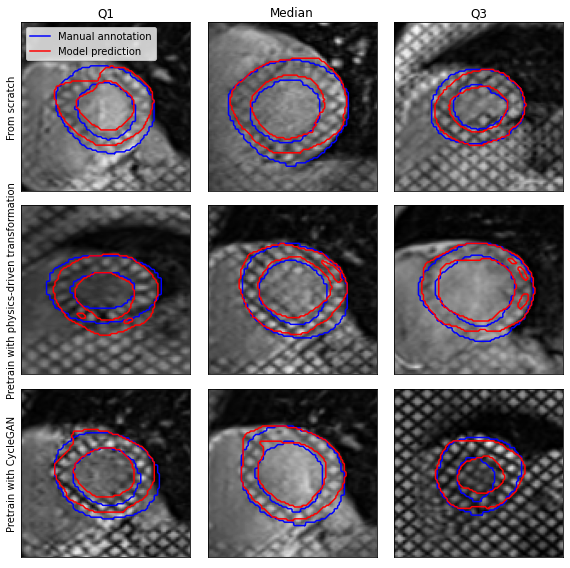

In [9]:
fig, ax = plt.subplots(len(df.strategy.unique()), 3, figsize=(8, 8))

padding = 50

for m, strategy in enumerate(df.strategy.unique()):

    subs = df[(df.architecture == 'nnUnet') & (df.strategy == strategy)].copy()

    for i, (title, quantile) in enumerate(zip(['Q1', 'Median', 'Q3'], subs.dice.quantile([.25, .5, .75]))):

        subs['diff'] = (subs.dice - quantile).abs()

        subject = subs.sort_values('diff', ascending=True).iloc[0]

        image = subject.image.data[0, 0].numpy()
        mask = subject['mask'].data[0, 0].numpy()
        pred = subject.pred.data[0, 0].numpy()

        center = [list(map(lambda a: a.mean(), np.where(mask == 1))), list(map(lambda a: a.mean(), np.where(pred == 1)))]

        ax[m, i].imshow(image, cmap='gray')

        # Label only once
        for j, contour in enumerate(skm.measure.find_contours(mask, level=.5)):
            ax[m, i].plot(*contour[:, ::-1].T, c='b', label='Manual annotation' if j == 0 else None)
        for j, contour in enumerate(skm.measure.find_contours(pred, level=.5)):
            ax[m, i].plot(*contour[:, ::-1].T, c='r', label='Model prediction' if j == 0 else None)

        ax[m, i].get_xaxis().set_ticks([])
        ax[m, i].get_yaxis().set_ticks([])

        center_y, center_x = np.array(center).mean(axis=0)
        ax[m, i].set_xlim(center_x - padding, center_x + padding)
        ax[m, i].set_ylim(center_y + padding, center_y - padding)
        
        ax[0, i].set_title(title)

    ax[m, 0].set_ylabel(strategy)

ax[0, 0].legend(loc='upper left')

plt.tight_layout()
plt.savefig('../../figures/qualitative-nnUnet.pdf', bbox_inches='tight')
plt.show()

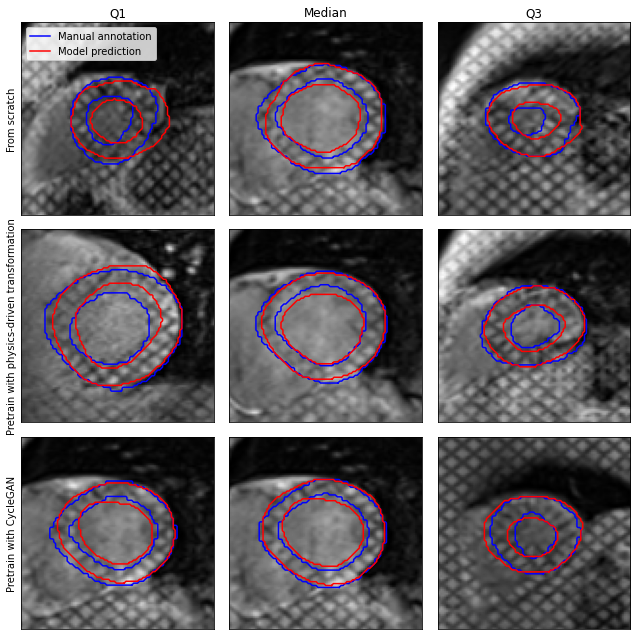

In [11]:
fig, ax = plt.subplots(len(df.strategy.unique()), 3, figsize=(9, 9))

padding = 50

for m, strategy in enumerate(df.strategy.unique()):

    subs = df[(df.architecture == 'ResNetVAE') & (df.strategy == strategy)].copy()

    for i, (title, quantile) in enumerate(zip(['Q1', 'Median', 'Q3'], subs.dice.quantile([.25, .5, .75]))):

        subs['diff'] = (subs.dice - quantile).abs()

        subject = subs.sort_values('diff', ascending=True).iloc[0]

        image = subject.image.data[0, 0].numpy()
        mask = subject['mask'].data[0, 0].numpy()
        pred = subject.pred.data[0, 0].numpy()

        center = [list(map(lambda a: a.mean(), np.where(mask == 1))), list(map(lambda a: a.mean(), np.where(pred == 1)))]

        ax[m, i].imshow(image, cmap='gray')

        # Label only once
        for j, contour in enumerate(skm.measure.find_contours(mask, level=.5)):
            ax[m, i].plot(*contour[:, ::-1].T, c='b', label='Manual annotation' if j == 0 else None)
        for j, contour in enumerate(skm.measure.find_contours(pred, level=.5)):
            ax[m, i].plot(*contour[:, ::-1].T, c='r', label='Model prediction' if j == 0 else None)

        ax[m, i].get_xaxis().set_ticks([])
        ax[m, i].get_yaxis().set_ticks([])
 
        center_y, center_x = np.array(center).mean(axis=0)
        ax[m, i].set_xlim(center_x - padding, center_x + padding)
        ax[m, i].set_ylim(center_y + padding, center_y - padding)

        ax[0, i].set_title(title)
        
    ax[m, 0].set_ylabel(strategy)

ax[0, 0].legend(loc='upper left')

plt.tight_layout()
# plt.savefig('../../figures/qualitative-ResNetVAE.pdf', bbox_inches='tight')
plt.show()